In [2]:
import torch
from torch import nn
from dataclasses import dataclass
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import numpy as np
import numpy
import timeit
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline 

In [3]:
@dataclass
class VitConfig:
    random_seed: int = 42
    batch_size: int = 512
    epochs: int = 1
    learning_rate: float = 1e-4
    num_classes: int = 10
    patch_size: int = 4
    image_size: int = 28
    input_channels: int = 1
    num_heads: int = 8
    dropout: float = 0.001
    hidden_dim: int = 768
    adam_weight_decay:int = 0
    adam_betas: tuple = (0.9, 0.999)
    activation: str = "gelu"
    num_encoders: int = 4
    embd_dim: int = (patch_size ** 2) * input_channels   # 16
    num_patches: int = (image_size // patch_size) ** 2   # 49
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
config = VitConfig

random.seed(config.random_seed)
numpy.random.seed(config.random_seed)
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, config : VitConfig):
        super().__init__()
        
        self.config = config
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=config.input_channels,
                out_channels=config.embd_dim,
                kernel_size=config.patch_size,
                stride=config.patch_size
            ),
            nn.Flatten(2)
        )
        
        self.cls_token = nn.Parameter(torch.randn(size=(1, config.input_channels, config.embd_dim)), requires_grad=True)
        self.positional_embeddings = nn.Parameter(torch.randn(size=(1, config.num_patches+1, config.embd_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=config.dropout)
        
    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.positional_embeddings + x
        x = self.dropout(x)
        return x

In [7]:
class ViT(nn.Module):
    def __init__(self, config: VitConfig):
        super().__init__()
         
        self.config = config
        self.embedding = PatchEmbedding(VitConfig)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=config.embd_dim, nhead=config.num_heads, dropout=config.dropout, activation=config.activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=config.num_encoders)
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=config.embd_dim),
            nn.Linear(in_features=config.embd_dim, out_features=config.num_classes)
        )
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:,0,:])   # only take CLS token (zero-token)
        return x

In [8]:
config = VitConfig
embd = ViT(VitConfig).to(config.device)
x = torch.randn(512, 1, 28, 28).to(config.device)
print(embd(x).shape)


c:\anaconda\envs\VIT_Venv\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([512, 10])


## dataset

In [8]:
train_df = pd.read_csv("digit-recognizer-data/train.csv")
test_df = pd.read_csv("digit-recognizer-data/test.csv")
submission_df = pd.read_csv("digit-recognizer-data/sample_submission.csv")

In [148]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=config.random_seed, shuffle=True)
train_df.shape, val_df.shape

((37800, 785), (4200, 785))

In [149]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5],
                std=[0.5]
            )
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index].reshape((28, 28)).astype(np.uint8)
        label = self.labels[index]
        index = self.indices[index]
        image = self.transform(image)
        return {
            "image" : image,
            "label" : label,
            "index" : index
        }
        
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5],
                std=[0.5]
            )
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index].reshape((28, 28)).astype(np.uint8)
        label = self.labels[index]
        index = self.indices[index]
        image = self.transform(image)
        return {
            "image" : image,
            "label" : label,
            "index" : index
        }
        
class MNISTTestDataset(Dataset):
    def __init__(self, images, indices):
        self.images = images
        self.indices = indices
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5],
                std=[0.5]
            )
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index].reshape((28, 28)).astype(np.uint8)
        index = self.indices[index]
        image = self.transform(image)
        return {
            "image" : image,
            "index" : index
        }

37800
------------------------------
4200
------------------------------
28000
------------------------------


<Figure size 640x480 with 0 Axes>

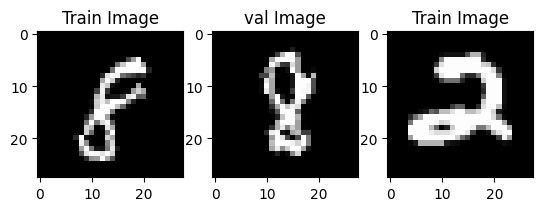

In [150]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_df))
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-" * 30)

val_dataset = MNISTTrainDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("val Image")
print("-" * 30)

test_dataset = MNISTTestDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Train Image")
print("-" * 30)


In [151]:
train_dataloader = DataLoader(
                            dataset=train_dataset,
                            batch_size=config.batch_size,
                            shuffle=True
                        )

val_dataloader = DataLoader(
                            dataset=val_dataset,
                            batch_size=config.batch_size,
                            shuffle=True
                        )

test_dataloader = DataLoader(
                            dataset=test_dataset,
                            batch_size=config.batch_size,
                            shuffle=False
                        )

In [9]:
model = ViT(VitConfig)

### Training

In [153]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=config.adam_betas, lr=config.learning_rate, weight_decay=config.adam_weight_decay)

start = timeit.default_timer()

for epoch in tqdm(range(config.epochs), position=0, leave=True, desc="epochs"):
    model.train()
    
    train_labels = []
    train_preds = []
    train_running_loss = 0
    
    for idx, image in enumerate(tqdm(train_dataloader, position=0, leave=True, desc="training")):
        img = image["image"].float().to(config.device)
        label = image["label"].type(torch.uint8).to(config.device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        
    train_loss = train_running_loss / (idx + 1)
    
    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_dataloader, position=0, leave=True, desc="validating")):
            img = image["image"].float().to(config.device)
            label = image["label"].type(torch.uint8).to(config.device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
            
    val_loss = val_running_loss/ (idx + 1)
    
    print("-"*30)
    print(f"Train loss epoch {epoch + 1}: {train_loss:.4f}")
    print(f"Val loss epoch {epoch + 1}: {val_loss:.4f}")
    print(f"Train Accuracy epoch {epoch + 1}: {sum(1 for x, y in zip(train_preds, train_labels) if x==y)/len(train_labels):.4f}")     
    print(f"Val Accuracy epoch {epoch + 1}: {sum(1 for x, y in zip(val_preds, val_labels) if x==y)/len(val_labels):.4f}")     
    
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

validating: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


------------------------------
Train loss epoch 1: 2.2559
Val loss epoch 1: 2.1041


epochs: 100%|██████████| 1/1 [03:49<00:00, 229.58s/it]

Train Accuracy epoch 1: 0.1579
Val Accuracy epoch 1: 0.2514
Training Time: 229.58s


In [154]:
torch.cuda.empty_cache()

In [155]:
labels = []
ids = []
imgs = []
model.eval()

with torch.no_grad():
    for idx, image in enumerate(tqdm(test_dataloader, position=0, leave=True, desc="Testing")):
        img = image["image"].to(config.device)
        ids.extend([int(i)+1 for i in image["index"]])
        
        preds = model(img)
        
        imgs.extend(img.cpu().detach())
        labels.extend([int(i) for i in torch.argmax(preds, dim=1)])

Testing: 100%|██████████| 55/55 [00:38<00:00,  1.41it/s]


<Figure size 640x480 with 0 Axes>

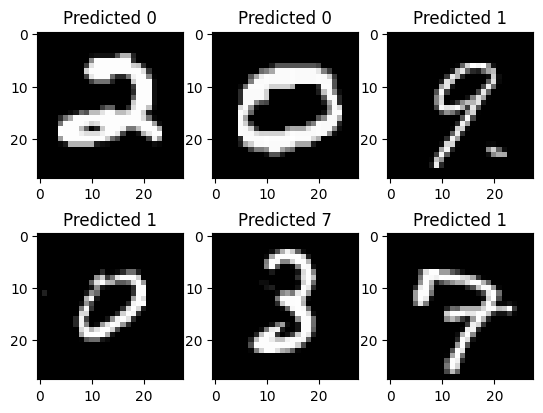

In [156]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [157]:

submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,1
3,4,1
4,5,7


In [1]:
from torchinfo import summary

In [12]:
summary(model=model, 
        input_size=(32, 1, 28, 28), 
        col_names= ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings= ["var_names"]
    )

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 1, 28, 28]      [32, 10]             --                   True
├─PatchEmbedding (embedding)                            [32, 1, 28, 28]      [32, 50, 16]         816                  True
│    └─Sequential (patcher)                             [32, 1, 28, 28]      [32, 16, 49]         --                   True
│    │    └─Conv2d (0)                                  [32, 1, 28, 28]      [32, 16, 7, 7]       272                  True
│    │    └─Flatten (1)                                 [32, 16, 7, 7]       [32, 16, 49]         --                   --
│    └─Dropout (dropout)                                [32, 50, 16]         [32, 50, 16]         --                   --
├─TransformerEncoder (encoder_blocks)                   [32, 50, 16]         [32, 50, 16]         --                   True
│    └─